In [35]:
from scipy.stats.mstats import winsorize
from shapely import Point
import datetime
import numpy as np
import pandas as pd
import contextily as cx
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from scipy.interpolate import griddata 
from mpl_toolkits.basemap import Basemap
from haversine import haversine

from simulator.disasters.generic.earthquake import Earthquake
from simulator.disasters.specific.drill_earthquake import DrillEarthQuake



In [7]:
gdf_panama = gpd.read_file("/Users/andreaparra/Dropbox/4_Work/data/shapefiles/panama/gadm41_PAN_shp/gadm41_PAN_2.shp")
gdf_panama.head()

,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,PAN.1.1_1,PAN,Panama,PAN.1_1,Bocas del Toro,NA,Bocas del Toro,NA,NA,Distrito,District,NA,PA.BC.BT,"MULTIPOLYGON (((-82.25736 9.16431, -82.25708 9..."
1,PAN.1.2_1,PAN,Panama,PAN.1_1,Bocas del Toro,NA,Changuinola,NA,NA,Distrito,District,NA,PA.BC.CH,"MULTIPOLYGON (((-82.76650 8.99789, -82.76719 8..."
2,PAN.1.3_1,PAN,Panama,PAN.1_1,Bocas del Toro,NA,Chiriquí Grande,NA,NA,Distrito,District,NA,PA.BC.CG,"MULTIPOLYGON (((-82.07708 8.92347, -82.07653 8..."
3,PAN.2.1_1,PAN,Panama,PAN.2_1,Chiriquí,NA,Alanje,NA,NA,Distrito,District,NA,PA.CH.AL,"POLYGON ((-82.52854 8.39068, -82.52721 8.39094..."
4,PAN.2.2_1,PAN,Panama,PAN.2_1,Chiriquí,NA,Barú,NA,NA,Distrito,District,NA,PA.CH.BR,"MULTIPOLYGON (((-82.88042 8.01931, -82.88042 8..."


In [2]:
drill_earthqauke = DrillEarthQuake()

In [3]:
d = datetime.datetime.strptime('2017-08-25 09:0:00', '%Y-%m-%d %H:%M:%S')
fun = drill_earthqauke.get_function_by_date(d)


   Generating Disaster
      Number of steps to compute: 87759 hr


,intensity,geometry,magnitude
0,8.552092e-07,"POLYGON ((-85.21993 7.74863, -85.24659 7.84964...",1.000000
1,1.643101e-06,"POLYGON ((-84.81180 8.05166, -84.82784 8.15267...",1.151960
2,3.114211e-06,"POLYGON ((-84.51124 8.35469, -84.51124 8.45570...",1.435692
3,5.822690e-06,"POLYGON ((-84.20651 8.15267, -84.22152 8.25368...",1.958074
4,1.073968e-05,"POLYGON ((-83.90555 8.05166, -83.93379 8.15267...",2.906408


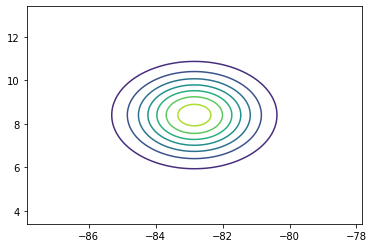

In [4]:
gdf = fun.generate_geopandas()
# gdf.rename(columns={"intensity": "margnitude"}, inplace=True)

# scale to richter
min_target = 1
max_target = 7.6

gdf["magnitude"] = ((max_target - min_target) * \
                    (gdf["intensity"] - gdf["intensity"].min()) / (gdf["intensity"].max() - gdf["intensity"].min())) + \
                     min_target

gdf.head()



In [7]:
density = [1.5 if i < 300 \
                   else 0 for i in [200, 4009, 10, 90, 300, 301]]
density



[1.5, 0, 1.5, 1.5, 0, 0]

In [6]:
with open("earthquake.geojson", 'w') as out:
    out.write(gdf.to_json())


In [9]:
from math import radians, sin, cos, asin, sqrt
import numpy as np

In [33]:
def haversine(lon1, lat1, lon2, lat2, rads = False):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    Taken from: https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    """
    # convert decimal degrees to radians 
    if not rads:
        lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371*1000 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

def np_haversine(lon1, lat1, lon2, lat2, rads = False):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    Taken from: https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    """
    # convert decimal degrees to radians 
    print(lon1, lat1, lon2, lat2)
    if not rads:
        lon1 = np.radians(lon1)
        lat1 = np.radians(lat1)
        lon2 = np.radians(lon2)
        lat2 = np.radians(lat1)

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + (np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2)
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [37]:
poi = [[8.424514, -82.793912], [8.869377, -83.153290]]
lat_1 = np.radians(poi[0][0])
lon_1 = np.radians(poi[0][1])
lat_2 = np.radians(poi[1][0])
lon_2 = np.radians(poi[1][1])

# np_haversine(-82.793912, 8.424514, -83.153290, 8.869377, rads = False)
haversine((8.424514, -82.793912), (8.869377, -83.153290), unit='km')

63.306594192363086

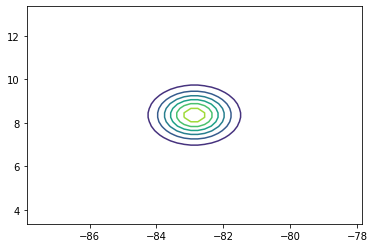

In [ ]:
gdf = t_0.generate_geopandas()

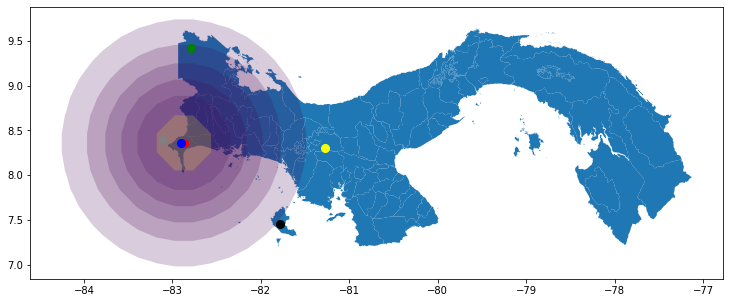

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))

# Points in shapely are Point(lon, lat)
pois = [Point(-82.869058, 8.360193), Point(-82.787767, 9.415969),  Point(-82.896869, 8.363514), 
        Point(-83.108523, 8.397710), Point(-81.274001, 8.302333), Point(-81.782823, 7.451571)]
colors = ["red", "green", "blue", "grey", "yellow", "black"]
gdf_panama.plot(ax=ax)
gdf.plot(column="intensity", ax=ax, alpha=0.2)
for idx, poi in enumerate(pois):
    ax.plot(poi.x, poi.y, color=colors[idx], marker='o',  markersize=8)


In [ ]:
# List of directions at every point
directions = t_0.direction(pois)
directions

[0.0,
 4.344000662116514,
 276.8841186175392,
 279.01609215692866,
 91.98390485624623,
 130.10572050664695]

In [ ]:
# List of bearings (degrees) at every point
intensities = t_0.intensity(pois)
intensities

[10.0,
 3.2586529489338627,
 9.99215826862586,
 9.429415215123937,
 0.7827283955533144,
 1.3459292664123554]

# FB data processor

### Population density

In [1]:
import os
import datetime
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from simulator.data_processors.generic.FB_population_density import FBPopulationDensity
import simulator.utils.facebook as fb_fun
import simulator.constants as con

/Users/andreaparra/Virtual-Envs/python_3.9/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(
<ipython-input-1-5b87847f432d>:4: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are usi

In [2]:
# 2023-03-01 13:55:26
base_dir = "/Users/andreaparra/Dropbox/4_Work/CrisisReady/synthetic_mobility_data/data/results"
data_dir = os.path.join(base_dir, "panama_costa_rica_drill")
out_dir = base_dir
data_processor = FBPopulationDensity(disaster_name="panama_costa_rica_drill", data_dir=data_dir, 
                                     crisis_datetime=datetime.datetime(2017, 8, 25, 8, 34, 0), agg_geometry='tile',
                                     out_dir=out_dir, baseline_cols=[])

In [3]:
data_processor.build_dataset()

Calulates fb population density statistics.
  Builds raw dataset.
    Loads files from disk.
    Done.
    Builds baseline.
    Builds crisis.
    Done.
All Done.


/Users/andreaparra/Virtual-Envs/python_3.9/lib/python3.9/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [4]:
data_processor.data().head()

,latitude,longitude,quadkey,n_baseline,n_baseline_std,date_time,n_crisis,n_difference,density_baseline,density_crisis,percent_change,z_score,ds
0,8.037473,-82.902832,03222121020013,285.764706,27.20186,2017-08-25 16:00:00,551,265.235294,0.00014,0.000269,92.492308,9.750631,2017-08-25
1,8.037473,-82.902832,03222121020013,285.764706,27.20186,2017-08-26 00:00:00,645,359.235294,0.00014,0.000315,125.271795,13.206277,2017-08-26
2,8.037473,-82.902832,03222121020013,285.764706,27.20186,2017-08-26 08:00:00,589,303.235294,0.00014,0.000288,105.743590,11.147594,2017-08-26
3,8.037473,-82.902832,03222121020013,285.764706,27.20186,2017-08-26 16:00:00,391,105.235294,0.00014,0.000191,36.697436,3.868680,2017-08-26
4,8.037473,-82.902832,03222121020013,285.764706,27.20186,2017-08-27 00:00:00,322,36.235294,0.00014,0.000157,12.635897,1.332089,2017-08-27


In [6]:
 def write_dataset_to_file(s):
    out_folder = "/Users/andreaparra/Dropbox/4_Work/CrisisReady/synthetic_mobility_data/data/results/disaster-name=panama_costa_rica_drill/dataset=population-density/scale=tile"
    
    if not os.path.exists(out_folder):
        os.mkdir(out_folder)

    for date in s.data()[con.DS].unique():
        for hour in [0, 8, 16]:
            # file naming conventions
            date_str = datetime.datetime.strftime(date, "%Y-%m-%d")
            hour_str = f"0{hour}00" if hour // 10 == 0 else f"{hour}00"
            file_name = f"{s.dataset_id()}_{date_str}_{hour_str}.csv"
            out_file = os.path.join(out_folder, file_name)

            df_tmp = s.data().loc[(s.data()[con.DS] == date) & (s.data()[con.DATE_TIME].dt.hour == hour)]
            df_tmp[con.DS] = date_str
            df_tmp[con.FB_TILE_POP_DENSITY_COLS].to_csv(out_file, index=False)

In [8]:
write_dataset_to_file(data_processor)

<ipython-input-6-9f912f9bc082>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp[con.DS] = date_str


In [10]:
data_processor.write_as_readymapper_output("/Users/andreaparra/Dropbox/4_Work/CrisisReady/synthetic_mobility_data/data/results/disaster-name=panama_costa_rica_drill/readymapper/datatset=population_density/scale=tile")

/Users/andreaparra/Dropbox/4_Work/CrisisReady/synthetic_mobility_data/synthetic_mobility_data_generator/simulator/data_processors/generic/FB_population_density.py:299: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[con.DATE_TIME] = df[con.DATE_TIME].dt.strftime(con.READYMAPPER_DT_FORMAT)
/Users/andreaparra/Virtual-Envs/python_3.9/lib/python3.9/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


### FB mobility

In [1]:
import os
import datetime
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from simulator.data_processors.generic.FB_mobility import FBMobility
import simulator.utils.facebook as fb_fun
import simulator.constants as con
import simulator.utils.general as fun

/Users/andreaparra/Virtual-Envs/python_3.9/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(
<ipython-input-1-7bafe99cb1d8>:4: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are usi

In [2]:
# 2023-03-01 13:55:26
scale = 'tile'
base_dir = "/Users/andreaparra/Dropbox/4_Work/CrisisReady/synthetic_mobility_data/data/results"
data_dir = os.path.join(base_dir, "panama_costa_rica_drill")
out_dir = base_dir
data_processor = FBMobility(disaster_name="panama_costa_rica_drill", data_dir=data_dir, 
                                     crisis_datetime=datetime.datetime(2017, 8, 25, 8, 34, 00), agg_geometry=scale,
                                     out_dir=out_dir, baseline_cols=[], geo_file="/Users/andreaparra/Dropbox/4_Work/CrisisReady/synthetic_mobility_data/data/costa_rica-panama/gadm41_CRI-PAN_2")

In [3]:
data_processor.build_dataset()

Calulates fb mobility statistics.
  Builds raw dataset.
    Loads files from disk.
    Done.
(8916004, 6)
(8916004, 7)
(4531084, 7)
(518521, 10)
    Builds baseline.
(290900, 10)
    Builds crisis.
(227621, 10)
    Done.


/Users/andreaparra/Virtual-Envs/python_3.9/lib/python3.9/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


All Done.


In [6]:
data_processor.data().head()

,start_latitude,start_longitude,end_latitude,end_longitude,start_quadkey,end_quadkey,n_baseline,n_baseline_std,date_time,day_of_week,hour,n_crisis,length_km,n_difference,percent_change,z_score,ds
0,8.037473,-82.902832,8.037473,-82.902832,03222121020013,03222121020013,60.176471,18.08741,2017-08-25 16:00:00,4,16,217,0.0,156.823529,256.346154,8.670314,2017-08-25
1,8.037473,-82.902832,8.037473,-82.902832,03222121020013,03222121020013,60.176471,18.08741,2017-08-26 00:00:00,5,0,131,0.0,70.823529,115.769231,3.915626,2017-08-26
2,8.037473,-82.902832,8.037473,-82.902832,03222121020013,03222121020013,60.176471,18.08741,2017-08-26 08:00:00,5,8,113,0.0,52.823529,86.346154,2.920458,2017-08-26
3,8.037473,-82.902832,8.037473,-82.902832,03222121020013,03222121020013,60.176471,18.08741,2017-08-26 16:00:00,5,16,74,0.0,13.823529,22.596154,0.764262,2017-08-26
4,8.037473,-82.902832,8.037473,-82.902832,03222121020013,03222121020013,60.176471,18.08741,2017-08-27 00:00:00,6,0,53,0.0,-7.176471,-11.730769,-0.396766,2017-08-27


In [5]:
cols = [con.FB_START_LATITUDE, con.FB_START_LONGITUDE, con.FB_END_LATITUDE, con.FB_END_LONGITUDE, con.LENGTH_KM, "start_GID_2", "end_GID_2", con.DATE_TIME, con.N_BASELINE, con.N_CRISIS, con.N_DIFFERENCE, con.
                        PERCENT_CHANGE, con.Z_SCORE, con.DS]

In [6]:
df= data_processor.data()
out_folder = "/Users/andreaparra/Dropbox/4_Work/CrisisReady/synthetic_mobility_data/data/results/disaster-name=panama_costa_rica_drill/dataset=mobility/scale=tile"

for date in df[con.DS].unique():
    for hour in [0, 8, 16]:
        # file naming conventions
        date_str = datetime.datetime.strftime(date, "%Y-%m-%d")
        hour_str = f"0{hour}00" if hour // 10 == 0 else f"{hour}00"
        file_name = f"{data_processor.dataset_id()}_{date_str}_{hour_str}.csv"
        out_file = os.path.join(out_folder, file_name)

        df_tmp = df.loc[(df[con.DS] == date) & (df[con.DATE_TIME].dt.hour == hour)]
        df_tmp[con.DS] = date_str
        if self.__agg_geometry == "tile":
            df_tmp[con.FB_TILE_MOBILITY_COLS].to_csv(out_file, index=False)
        elif self.__agg_geometry == "admin":
            df_tmp[con.FB_ADMIN_MOBILITY_COLS].to_csv(out_file, index=False)

NameError: name 'self' is not defined

In [8]:
date = df[con.DS].unique()[0]
hour = "8"
df_tmp = df.loc[(df[con.DS] == date) & (df[con.DATE_TIME] == hour)]

df_tmp.head()

,start_latitude,start_longitude,end_latitude,end_longitude,start_quadkey,end_quadkey,n_baseline,n_baseline_std,date_time,day_of_week,hour,n_crisis,length_km,n_difference,percent_change,z_score,ds


In [ ]:
def write_dataset_to_file(s):
    
    
    if not os.path.exists(out_folder):
        os.mkdir(out_folder)

    for date in self.__data[con.DS].unique():
        for hour in [0, 8, 16]:
            # file naming conventions
            date_str = datetime.datetime.strftime(date, "%Y-%m-%d")
            hour_str = f"0{hour}00" if hour // 10 == 0 else f"{hour}00"
            file_name = f"{self.dataset_id()}_{date_str}_{hour_str}.csv"
            out_file = os.path.join(out_folder, file_name)

            df_tmp = self.__data.loc[(self.__data[con.DS] == date) & (self.__data[con.DATE_TIME] == hour)]
            df_tmp[con.DS] = date_str
            if self.__agg_geometry == "tile":
                df_tmp[con.FB_TILE_MOBILITY_COLS].to_csv(out_file, index=False)
            elif self.__agg_geometry == "admin":
                df_tmp[con.FB_ADMIN_MOBILITY_COLS].to_csv(out_file, index=False)

In [9]:
out_folder = f"/Users/andreaparra/Dropbox/4_Work/CrisisReady/synthetic_mobility_data/data/results/disaster-name=panama_costa_rica_drill/readymapper/dataset=mobility/scale={scale}"
data_processor.write_as_readymapper_output(out_folder)

/Users/andreaparra/Dropbox/4_Work/CrisisReady/synthetic_mobility_data/synthetic_mobility_data_generator/simulator/data_processors/generic/FB_mobility.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[con.DATE_TIME] = df[con.DATE_TIME].dt.strftime(con.READYMAPPER_MOV_DT_FORMAT)
/Users/andreaparra/Virtual-Envs/python_3.9/lib/python3.9/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
